# Zero Shot Learning - Cross Lingual Named Entity Recognition with XLM-Roberta

## [Link to my Youtube Video Explaining this whole Notebook](https://www.youtube.com/watch?v=urMUa4Nw_B8&list=PLxqBkZuBynVQEvXfJpq3smfuKq3AiNW-N&index=7)

[![Imgur](https://imgur.com/oOpkFLo.png)](https://www.youtube.com/watch?v=urMUa4Nw_B8&list=PLxqBkZuBynVQEvXfJpq3smfuKq3AiNW-N&index=7)



## First What is BERT?

BERT stands for Bidirectional Encoder Representations from Transformers. The name itself gives us several clues to what BERT is all about.

BERT architecture consists of several Transformer encoders stacked together. Each Transformer encoder encapsulates two sub-layers: a self-attention layer and a feed-forward layer.

### There are two different BERT models:

- BERT base, which is a BERT model consists of 12 layers of Transformer encoder, 12 attention heads, 768 hidden size, and 110M parameters.

- BERT large, which is a BERT model consists of 24 layers of Transformer encoder,16 attention heads, 1024 hidden size, and 340 parameters.



BERT Input and Output
BERT model expects a sequence of tokens (words) as an input. In each sequence of tokens, there are two special tokens that BERT would expect as an input:

- [CLS]: This is the first token of every sequence, which stands for classification token.
- [SEP]: This is the token that makes BERT know which token belongs to which sequence. This special token is mainly important for a next sentence prediction task or question-answering task. If we only have one sequence, then this token will be appended to the end of the sequence.


It is also important to note that the maximum size of tokens that can be fed into BERT model is 512. If the tokens in a sequence are less than 512, we can use padding to fill the unused token slots with [PAD] token. If the tokens in a sequence are longer than 512, then we need to do a truncation.

And that’s all that BERT expects as input.

BERT model then will output an embedding vector of size 768 in each of the tokens. We can use these vectors as an input for different kinds of NLP applications, whether it is text classification, next sentence prediction, Named-Entity-Recognition (NER), or question-answering.


------------

**For a text classification task**, we focus our attention on the embedding vector output from the special [CLS] token. This means that we’re going to use the embedding vector of size 768 from [CLS] token as an input for our classifier, which then will output a vector of size the number of classes in our classification task.

-----------------------

![Imgur](https://imgur.com/NpeB9vb.png)

-------------------------

### In this Notebook, I will fine-tune XLM-R on the German corpus dataset and will see it yields an F1-score of around 85%

### And then without any additional training or fine-tuning I will apply that same model on some other languages in our corpus and in those other languages I will achieve some modest performance.

-----------


### What’s New in XLM-Roberta?

The Facebook AI team released XLM-RoBERTa in November 2019 as an update to their original XLM-100 model. Both are transformer based language models, both rely on the Masked Language Model objective and both are capable of processing text from 100 separate languages. The biggest update that XLM-Roberta offers over the original is a significantly increased amount of training data. The cleaned CommonCrawl data that it is trained on takes up a whopping 2.5tb of storage! It is several orders of magnitude larger than the Wiki-100 corpus that was used to train its predecessor and the scale-up is particularly noticeable in the lower resourced languages. The “RoBERTa” part comes from the fact that its training routine is the same as the monolingual RoBERTa model, specifically, that the sole training objective is the Masked Language Model. 

There is no Next Sentence Prediction like BERT or Sentence Order Prediction like ALBERT.

-----------



In [ ]:
!pip install transformers datasets seqeval -q

In [ ]:
import numpy as np

from seqeval.metrics import f1_score
from transformers import EvalPrediction

from transformers import TrainingArguments
from datasets import get_dataset_config_names
from datasets import load_dataset

from transformers import DataCollatorForTokenClassification

from collections import defaultdict
from datasets import DatasetDict

from collections import Counter

from transformers import Trainer

import torch.nn as nn
from matplotlib import pyplot as plt
from transformers import XLMRobertaConfig
from transformers.modeling_outputs import TokenClassifierOutput
from transformers.models.roberta.modeling_roberta import RobertaModel
from transformers.models.roberta.modeling_roberta import RobertaPreTrainedModel

import torch

from transformers import AutoConfig
from transformers import AutoTokenizer

from seqeval.metrics import classification_report

In [3]:
xtreme_subsets = get_dataset_config_names("xtreme")
print(f"XTREME has {len(xtreme_subsets)} configurations")

XTREME has 183 configurations


In [4]:
#  Let’s narrow the search by just looking for the configurations that start with “PAN”:

panx_subsets = [s for s in xtreme_subsets if s.startswith("PAN")]
panx_subsets[:3]

['PAN-X.af', 'PAN-X.ar', 'PAN-X.bg']

In [5]:

load_dataset("xtreme", name="PAN-X.de")

Reusing dataset xtreme (/root/.cache/huggingface/datasets/xtreme/PAN-X.de/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4)


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 20000
    })
    validation: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 10000
    })
})

In [6]:
languages = ["de", "fr", "it", "en"]
percentage_lang_spoken = [0.629, 0.229, 0.084, 0.059]
# Return a DatasetDict if a key doesn't exist
panx_ds_combined = defaultdict(DatasetDict)


In [ ]:

for lang, percentage in zip(languages, percentage_lang_spoken):
    # Load monolingual corpus
    ds = load_dataset("xtreme", name=f"PAN-X.{lang}")
    # Shuffle and downsample each train_test_val according to spoken proportion
    for train_test_val in ds:
        panx_ds_combined[lang][train_test_val] = (
            ds[train_test_val]
            .shuffle(seed=0)
            .select(range(int(percentage * ds[train_test_val].num_rows))))

In [8]:
panx_ds_combined

defaultdict(datasets.dataset_dict.DatasetDict,
            {'de': DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 12580
    })
    validation: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 6290
    })
    test: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 6290
    })
}),
             'en': DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 1180
    })
    validation: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 590
    })
    test: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 590
    })
}),
             'fr': DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 4580
    })
    validation: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 2290
    })
    test: Dataset(

In [9]:
import pandas as pd

pd.DataFrame({lang: [panx_ds_combined[lang]["train"].num_rows] for lang in languages},
             index=["Number of training examples"])

,de,fr,it,en
Number of training examples,12580,4580,1680,1180


In [10]:
element = panx_ds_combined["de"]["train"][0]

for key, value in element.items():
    print(f"{key}: {value}")

tokens: ['2.000', 'Einwohnern', 'an', 'der', 'Danziger', 'Bucht', 'in', 'der', 'polnischen', 'Woiwodschaft', 'Pommern', '.']
ner_tags: [0, 0, 0, 0, 5, 6, 0, 0, 5, 5, 6, 0]
langs: ['de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de']


### The keys here correspond to the column names of an Arrow table, while the values denote the entries in each column. 

In particular, we see that the ner_tags column corresponds to the mapping of each entity to a class ID. Each number in this class ID for ner_tags represents an entity. We can Convert the number to a label name for more information:

https://huggingface.co/docs/transformers/tasks/token_classification

This class IDs are not understandable to the human eye, so let’s create a new column with the familiar LOC, PER, and ORG tags. 

To do this, the first thing to notice is that our **Dataset object has a features attribute that specifies the underlying data types associated with each column**


In [11]:
panx_ds_combined["de"]['train']

Dataset({
    features: ['tokens', 'ner_tags', 'langs'],
    num_rows: 12580
})

In [12]:
for key, value in panx_ds_combined["de"]["train"].features.items():
    print(f"{key}: {value}")

tokens: Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)
ner_tags: Sequence(feature=ClassLabel(num_classes=7, names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], id=None), length=-1, id=None)
langs: Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)


In [13]:
tags = panx_ds_combined["de"]["train"].features["ner_tags"].feature
print(tags)

ClassLabel(num_classes=7, names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], id=None)


In [14]:
panx_ds_combined["de"]

DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 12580
    })
    validation: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 6290
    })
    test: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 6290
    })
})

In [15]:

def create_tag_names(batch):
    return {"ner_tags_str": [tags.int2str(idx) for idx in batch["ner_tags"]]}

panx_de = panx_ds_combined["de"].map(create_tag_names)

Loading cached processed dataset at /root/.cache/huggingface/datasets/xtreme/PAN-X.de/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-204dccd4212a347d.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/xtreme/PAN-X.de/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-28cc9172fa0bd1d3.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/xtreme/PAN-X.de/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-973a02444af226e2.arrow


The ClassLabel.int2str() method converts integer => class name string. In here, it will create a new column named **'ner_tags_str'** in our training set with class names for each tag. 

https://huggingface.co/docs/datasets/v2.4.0/en/package_reference/main_classes#datasets.ClassLabel.int2str

The map() method returns a dict with the key corresponding to the new column name and the value as a list of class names:


In [16]:
panx_de

DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags', 'langs', 'ner_tags_str'],
        num_rows: 12580
    })
    validation: Dataset({
        features: ['tokens', 'ner_tags', 'langs', 'ner_tags_str'],
        num_rows: 6290
    })
    test: Dataset({
        features: ['tokens', 'ner_tags', 'langs', 'ner_tags_str'],
        num_rows: 6290
    })
})

In [17]:
 panx_de["train"][0]

{'langs': ['de',
  'de',
  'de',
  'de',
  'de',
  'de',
  'de',
  'de',
  'de',
  'de',
  'de',
  'de'],
 'ner_tags': [0, 0, 0, 0, 5, 6, 0, 0, 5, 5, 6, 0],
 'ner_tags_str': ['O',
  'O',
  'O',
  'O',
  'B-LOC',
  'I-LOC',
  'O',
  'O',
  'B-LOC',
  'B-LOC',
  'I-LOC',
  'O'],
 'tokens': ['2.000',
  'Einwohnern',
  'an',
  'der',
  'Danziger',
  'Bucht',
  'in',
  'der',
  'polnischen',
  'Woiwodschaft',
  'Pommern',
  '.']}

In [18]:

de_example = panx_de["train"][0]
pd.DataFrame([de_example["tokens"], de_example["ner_tags_str"]],
['Tokens', 'Tags'])

,0,1,2,3,4,5,6,7,8,9,10,11
Tokens,2.000,Einwohnern,an,der,Danziger,Bucht,in,der,polnischen,Woiwodschaft,Pommern,.
Tags,O,O,O,O,B-LOC,I-LOC,O,O,B-LOC,B-LOC,I-LOC,O


In [19]:
from collections import Counter

def get_ner_frequencies(panx_de):
  split2freqs = defaultdict(Counter)
  for split, dataset in panx_de.items():
      for row in dataset["ner_tags_str"]:
          for tag in row:
              if tag.startswith("B"):
                  tag_type = tag.split("-")[1]
                  split2freqs[split][tag_type] += 1
  return split2freqs

freqs = get_ner_frequencies(panx_de)

pd.DataFrame.from_dict(freqs, orient="index")

,LOC,ORG,PER
train,6186,5366,5810
validation,3172,2683,2893
test,3180,2573,3071


### Creating a Custom Model for Token Classification

In [20]:
import torch.nn as nn
from matplotlib import pyplot as plt
from transformers import XLMRobertaConfig
from transformers.modeling_outputs import TokenClassifierOutput
from transformers.models.roberta.modeling_roberta import RobertaModel
from transformers.models.roberta.modeling_roberta import RobertaPreTrainedModel

class XLMRobertaForTokenClassification(RobertaPreTrainedModel):
    """
    This class extends the RobertaPreTrainedModel class for token classification tasks.
    The model architecture is based on the XLMRoberta model.
    """
    config_class = XLMRobertaConfig

    def __init__(self, config):
        """
        Constructor for the XLMRobertaForTokenClassification class.
        
        Parameters:
        config (XLMRobertaConfig): Configuration object containing information about how to build the model.
        """
        super().__init__(config)
        self.num_labels = config.num_labels
        # Load model body
        self.roberta = RobertaModel(config, add_pooling_layer=False)
        # Set up token classification head
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)
        # Load and initialize weights
        self.init_weights()

    def forward(self, input_ids=None, attention_mask=None, token_type_ids=None, 
                labels=None, **kwargs):
        """
        Forward method for the XLMRobertaForTokenClassification class.
        
        Parameters:
        input_ids (torch.Tensor): Tensor of input ids of shape (batch_size, sequence_length).
        attention_mask (torch.Tensor): Tensor of attention masks of shape (batch_size, sequence_length).
        token_type_ids (torch.Tensor): Tensor of token type ids of shape (batch_size, sequence_length).
        labels (torch.Tensor): Tensor of labels of shape (batch_size, sequence_length).
        
        Returns:
        TokenClassifierOutput: An object that contains the loss and the logits.
        """
        # Use model body to get encoder representations
        outputs = self.roberta(input_ids, attention_mask=attention_mask,
                               token_type_ids=token_type_ids, **kwargs)
        # Apply classifier to encoder representation
        sequence_output = self.dropout(outputs[0])
        logits = self.classifier(sequence_output)
        # Calculate losses
        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
        # Return model output object
        return TokenClassifierOutput(loss=loss, logits=logits, 
                                     hidden_states=outputs.hidden_states, 
                                     attentions=outputs.attentions)

-------------
## TFTokenClassifierOutput


https://huggingface.co/docs/transformers/main_classes/output#transformers.modeling_tf_outputs.TFTokenClassifierOutput


All models have outputs that are instances of subclasses of ModelOutput. Those are data structures containing all the information returned by the model, but that can also be used as tuples or dictionaries.


The outputs object is a SequenceClassifierOutput, as we can see in the documentation of that class below, it means it has an optional loss, a logits an optional hidden_states and an optional attentions attribute. Here we have the loss since we passed along labels, but we don’t have hidden_states and attentions because we didn’t pass output_hidden_states=True or output_attentions=True.


-------------

In [21]:
index2tag = {idx: tag for idx, tag in enumerate(tags.names)}
tag2index = {tag: idx for idx, tag in enumerate(tags.names)}

In [22]:
index2tag
'''
{0: 'O',
 1: 'B-PER',
 2: 'I-PER',
 3: 'B-ORG',
 4: 'I-ORG',
 5: 'B-LOC',
 6: 'I-LOC'} '''

"\n{0: 'O',\n 1: 'B-PER',\n 2: 'I-PER',\n 3: 'B-ORG',\n 4: 'I-ORG',\n 5: 'B-LOC',\n 6: 'I-LOC'} "

In [23]:
tag2index

{'B-LOC': 5,
 'B-ORG': 3,
 'B-PER': 1,
 'I-LOC': 6,
 'I-ORG': 4,
 'I-PER': 2,
 'O': 0}

In [24]:
bert_model_name = "bert-base-cased"
xlmr_model_name = "xlm-roberta-base"

bert_tokenizer = AutoTokenizer.from_pretrained(bert_model_name)
xlmr_tokenizer = AutoTokenizer.from_pretrained(xlmr_model_name)

In [25]:

xlmr_config = AutoConfig.from_pretrained(xlmr_model_name, 
                                         num_labels=tags.num_classes,
                                         id2label=index2tag, label2id=tag2index)

In [26]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = 'cpu'

xlmr_my_model = (XLMRobertaForTokenClassification
              .from_pretrained(xlmr_model_name, config=xlmr_config)
              .to(device))

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForTokenClassification: ['lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['roberta.embeddings.position_

In [27]:
example_string = 'World will be changed with AI'

bert_tokens = bert_tokenizer(example_string).tokens()
xlmr_tokens = xlmr_tokenizer(example_string).tokens()

In [28]:
xlmr_tokens
# ['<s>', '▁World', '▁will', '▁be', '▁changed', '▁with', '▁AI', '</s>']['<s>', '▁World', '▁will', '▁be', '▁changed', '▁with', '▁AI', '</s>']

['<s>', '▁World', '▁will', '▁be', '▁changed', '▁with', '▁AI', '</s>']

In [29]:
def tag_text(text, tags, model, tokenizer):
    """
    Function to tag text using a pretrained model and tokenizer.

    Parameters:
    text (str): Text to be tagged.
    tags (Tags): An instance of the Tags class that maps class indices to names.
    model (Model): Pretrained model for named entity recognition.
    tokenizer (Tokenizer): Pretrained tokenizer corresponding to the model.

    Returns:
    pd.DataFrame: DataFrame containing the original tokens and their corresponding tags.
    """
    # Tokenize the text, preserving special characters
    tokens = tokenizer(text).tokens()

    # Encode the tokens into their corresponding IDs
    # 'return_tensors="pt"' indicates that we want PyTorch tensors
    # '.to(device)' sends the tensors to the GPU if one is available
    input_ids = tokenizer(text, return_tensors="pt").input_ids.to(device)

    # Print the input IDs for debugging purposes
    print('input_ids ', input_ids)

    # Get the model's predictions as a distribution over possible classes
    # Each token is associated with a probability distribution over the 7 possible NER tags
    outputs = model(input_ids)[0]
    print(f"Shape of outputs: {outputs.shape}")

    # Take the argmax over the tag dimension to get the most likely class for each token
    predictions = torch.argmax(outputs, dim=2)
    print('predictions ', predictions)

    # Convert the predictions from class indices to class names using the 'tags' object
    # '.cpu().numpy()' moves the tensor from GPU to CPU and converts it to a NumPy array
    preds = [tags.names[p] for p in predictions[0].cpu().numpy()]

    # Return the tokens and their corresponding tags as a DataFrame
    return pd.DataFrame([tokens, preds], index=["Tokens", "Tags"])


In [30]:
print(tags)
print(xlmr_tokenizer)

ClassLabel(num_classes=7, names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], id=None)
PreTrainedTokenizerFast(name_or_path='xlm-roberta-base', vocab_size=250002, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=False)})


In [31]:
tag_text(example_string, tags, xlmr_my_model, xlmr_tokenizer )

input_ids  tensor([[    0,  6661,  1221,   186, 98816,   678, 38730,     2]],
       device='cuda:0')
Shape of outputs: torch.Size([1, 8, 7])
predictions  tensor([[2, 2, 2, 2, 2, 2, 2, 2]], device='cuda:0')


,0,1,2,3,4,5,6,7
Tokens,<s>,▁World,▁will,▁be,▁changed,▁with,▁AI,</s>
Tags,I-PER,I-PER,I-PER,I-PER,I-PER,I-PER,I-PER,I-PER


In [32]:
words, labels = de_example["tokens"], de_example["ner_tags"]

Next, we tokenize each word and use the **`is_split_into_words`** argument to tell
the tokenizer that our input sequence has already been split into words:

**From Doc - is_split_into_words (bool, optional, defaults to False)** — If set to True, the tokenizer assumes the input is already split into words (for instance, by splitting it on whitespace) which it will tokenize. This is useful for NER or token classification.


https://github.com/huggingface/transformers/issues/8217

#### **`is_split_into_words`** DOES NOT MEAN that the text was already pre-tokenized. It just means that the string was split into words (not tokens), i.e., split on spaces.

In [33]:
tokenized_input = xlmr_tokenizer(de_example["tokens"], is_split_into_words=True)

tokens = xlmr_tokenizer.convert_ids_to_tokens(tokenized_input["input_ids"])

In [34]:

pd.DataFrame([tokens], index=["Tokens"])

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Tokens,<s>,▁2.000,▁Einwohner,n,▁an,▁der,▁Dan,zi,ger,▁Buch,...,▁Wo,i,wod,schaft,▁Po,mmer,n,▁,.,</s>


In this example we can see that the tokenizer has split “Einwohnern” into two
subwords, “▁Einwohner” and “n”. 

Since we’re following the convention that only “▁Einwohner” should be associated with the B-LOC label, we need a way to mask the subword representations after the first subword. 

And for this purpose, tokenizer contains a word_ids() function that can help us achieve this:


## word_ids()

https://huggingface.co/docs/transformers/main_classes/tokenizer#transformers.BatchEncoding.word_ids  

Return a list mapping the tokens to their actual word in the initial sentence for a fast tokenizer. It Returns a list indicating the word corresponding to each token. 

### In word_ids() the Special tokens added by the tokenizer are mapped to None and other tokens are mapped to the index of their corresponding word (several tokens will be mapped to the same word index if they are parts of that word).

Returns a list like below..

```
[None, 0, 1, 1, 2, 3, 4, 4, 4, 5, 5, 6, 7, 8, 8, 9, 9, 9, 9, 10, 10, 10, 11, 11, None]
0	1	2	3	4	5	6	7	8	9	...	15	16	17	18	19	20	21	22	23	24
```

In [35]:

word_ids = tokenized_input.word_ids()
print('word_ids ', word_ids)

pd.DataFrame([tokens, word_ids], index=["Tokens", "Word IDs"])

word_ids  [None, 0, 1, 1, 2, 3, 4, 4, 4, 5, 5, 6, 7, 8, 8, 9, 9, 9, 9, 10, 10, 10, 11, 11, None]


,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Tokens,<s>,▁2.000,▁Einwohner,n,▁an,▁der,▁Dan,zi,ger,▁Buch,...,▁Wo,i,wod,schaft,▁Po,mmer,n,▁,.,</s>
Word IDs,None,0,1,1,2,3,4,4,4,5,...,9,9,9,9,10,10,10,11,11,None


In [36]:

previous_word_idx = None
label_ids = []

for word_idx in word_ids:
    if word_idx is None or word_idx == previous_word_idx:
        label_ids.append(-100)
    elif word_idx != previous_word_idx:
        label_ids.append(labels[word_idx])
    # And then update previous_word_idx
    # to be current word
    previous_word_idx = word_idx

print('label_ids ', label_ids)
    
labels = [index2tag[l] if l != -100 else "IGN" for l in label_ids]
index = ["Tokens", "Word IDs", "Label IDs", "Labels"]

pd.DataFrame([tokens, word_ids, label_ids, labels], index=index)

label_ids  [-100, 0, 0, -100, 0, 0, 5, -100, -100, 6, -100, 0, 0, 5, -100, 5, -100, -100, -100, 6, -100, -100, 0, -100, -100]


,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Tokens,<s>,▁2.000,▁Einwohner,n,▁an,▁der,▁Dan,zi,ger,▁Buch,...,▁Wo,i,wod,schaft,▁Po,mmer,n,▁,.,</s>
Word IDs,None,0,1,1,2,3,4,4,4,5,...,9,9,9,9,10,10,10,11,11,None
Label IDs,-100,0,0,-100,0,0,5,-100,-100,6,...,5,-100,-100,-100,6,-100,-100,0,-100,-100
Labels,IGN,O,O,IGN,O,O,B-LOC,IGN,IGN,I-LOC,...,B-LOC,IGN,IGN,IGN,I-LOC,IGN,IGN,O,IGN,IGN


### Let’s set –100 as the label for these special tokens and the subwords we wish to mask during training:
Why did we choose –100 as the ID to mask subword representations? The reason is
that in PyTorch the cross-entropy loss class torch.nn.CrossEntropyLoss has an
attribute called ignore_index whose value is –100. This index is ignored during
training, so we can use it to ignore the tokens associated with consecutive
subwords.

In [37]:
def tokenize_mask_modify_labels(examples):
    """
    Function to tokenize the input text, mask certain tokens, and adjust the labels accordingly.

    Parameters:
    examples (dict): A dictionary containing the input text and labels. The input text ("tokens") is a list of words, 
                     and the labels ("ner_tags") are a corresponding list of NER tags.

    Returns:
    tokenized_inputs (dict): A dictionary containing the tokenized input text and modified labels. The tokenized input 
                             text is a list of token IDs, and the modified labels are a corresponding list of NER tags, 
                             with -100 indicating masked tokens.
    """
    tokenized_inputs = xlmr_tokenizer(examples["tokens"], truncation=True, 
                                      is_split_into_words=True)
    labels = []
    for idx, label in enumerate(examples["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=idx)
        # word_ids() => Return a list mapping the tokens
        # to their actual word in the initial sentence.
        # It Returns a list indicating the word corresponding to each token. 
        previous_word_idx = None
        label_ids = []
        # Special tokens like `<s>` and `<\s>` are mapped to None. 
        # Set –100 as the label for these special tokens and
        # the subwords we wish to mask during training:
        for word_idx in word_ids:
            if word_idx is None or word_idx == previous_word_idx:
                label_ids.append(-100)
            else:
                label_ids.append(label[word_idx])
            previous_word_idx = word_idx
        labels.append(label_ids)
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

## Map

https://huggingface.co/docs/datasets/process#map

Some of the more powerful applications of 🤗 Datasets come from using the map() function. The primary purpose of map() is to speed up processing functions. It allows you to apply a processing function to each example in a dataset, independently or in batches. This function can even create new rows and columns.

**batched (bool, default False)** — Provide batch of examples to function.

**remove_columns (Optional[Union[str, List[str]]], default None)** — Remove a selection of columns while doing the mapping. Columns will be removed before updating the examples with the output of function, i.e. if function is adding columns with names in remove_columns, these columns will be kept.

In [38]:
def encode_panx_dataset(corpus):
    return corpus.map(tokenize_mask_modify_labels, batched=True, 
                      remove_columns=['langs', 'ner_tags', 'tokens'])

In [39]:

panx_de_encoded = encode_panx_dataset(panx_ds_combined["de"])

Loading cached processed dataset at /root/.cache/huggingface/datasets/xtreme/PAN-X.de/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-08d84fb9fdc079b2.arrow


  0%|          | 0/7 [00:00<?, ?ba/s]

Loading cached processed dataset at /root/.cache/huggingface/datasets/xtreme/PAN-X.de/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-c1c2d298fc80b661.arrow


In [40]:
from seqeval.metrics import classification_report

y_true = [["O", "O", "O", "B-MISC", "I-MISC", "I-MISC", "O"],
          ["B-PER", "I-PER", "O"]]
y_pred = [["O", "O", "B-MISC", "I-MISC", "I-MISC", "I-MISC", "O"],
          ["B-PER", "I-PER", "O"]]
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

        MISC       0.00      0.00      0.00         1
         PER       1.00      1.00      1.00         1

   micro avg       0.50      0.50      0.50         2
   macro avg       0.50      0.50      0.50         2
weighted avg       0.50      0.50      0.50         2



The seqeval package expects the predictions and labels as lists of lists, with
each list corresponding to a single example in our validation or test sets. To
integrate these metrics during training, we need a function that can take the
outputs of the model and convert them into the lists that seqeval expects. The
following does the trick by ensuring we ignore the label IDs associated with
subsequent subwords:


-----

Noting down the below variables, as was calculated earlier in this NB, but see that in the following function `generate_list_for_compute_metrics` these same variables are not used.

label_ids => [-100, 'IGN', 'O', -100, 'O', 'IGN', 'O', -100, -100, 'O', -100, 'B-LOC', 'IGN', 'IGN', -100, 'I-LOC', -100, -100, -100, 'IGN', -100, -100, 'O', -100, -100]


predictions will be =>  tensor([[2, 2, 2, 2, 2, 2, 2, 2]])


-----

## EvalPrediction

#### EvalPrediction - Inside `compute_metrics()` when I print `eval_pred` - It Will output below

<transformers.trainer_utils.EvalPrediction>

https://huggingface.co/docs/transformers/internal/trainer_utils#transformers.EvalPrediction


### `class transformers.EvalPrediction`

Parameters

* predictions (np.ndarray) — Predictions of the model.
* label_ids (np.ndarray) — Targets to be matched.
* inputs (np.ndarray, optional) —

Evaluation output (always contains labels), to be used to compute metrics.

### What does EvalPrediction.predictions contain exactly?

The Trainer will put in **`predictions`** everything your model returns (apart from the loss).

### When I print `eval_pred.predictions` - I get below a 3D-Tensor

```
[[[ 5.5185753e-01 -2.7944833e-01 -7.5236917e-01 ...  3.5712823e-01
   -6.6847444e-01  2.7783272e-01]
  [-6.0417420e-01  1.7045190e+00 -3.0190976e+00 ... -8.1113666e-01
    1.5366187e+00 -3.7904561e+00]
  [-5.0854206e-01 -1.9779130e+00  9.6103489e-02 ...  4.6591806e+00
   -1.7985896e+00 -6.7350179e-01]
```

And note within the `generate_list_for_compute_metrics` function I do below to get the Preds

`preds = np.argmax(predictions, axis=2)`


### When I print `eval_pred.label_ids` - I get below a 3D-Tensor

```
[[-100    3 -100 ... -100 -100 -100]
 [-100    0 -100 ... -100 -100 -100]
 [-100    0    0 ... -100 -100 -100]
  ...
 [-100    0    0 ... -100 -100 -100]
 [-100    0    0 ... -100 -100 -100]
 [-100    0    0 ... -100 -100 -100]]

```

In above each list corresponding to a single example in our validation or test sets. 

------------

In [41]:
import numpy as np

def generate_list_for_compute_metrics(predictions, label_ids):
    """
    Function to generate prediction and true labels lists for computing metrics.

    Parameters:
    predictions (np.ndarray): A 2D numpy array containing the predicted label IDs for each token in each example.
    label_ids (np.ndarray): A 2D numpy array containing the true label IDs for each token in each example.

    Returns:
    preds_labels_list (list): A list of lists, where each sublist contains the predicted labels for each token in an example.
    true_labels_list (list): A list of lists, where each sublist contains the true labels for each token in an example.
    """
    # Get the predicted labels by taking the argmax over the second dimension of the predictions array
    preds = np.argmax(predictions, axis=2)
    batch_size, seq_len = preds.shape
    preds_labels_list, true_labels_list = [], []

    # Iterate over each example in the batch
    for batch_idx in range(batch_size):
        example_labels, example_preds = [], []
        # Iterate over each token in the example
        for seq_idx in range(seq_len):
            # Ignore tokens with label ID = -100 (these are special tokens or subwords that we masked during training)
            if label_ids[batch_idx, seq_idx] != -100:
                # Append the predicted and true labels for the token to the lists for the current example
                example_preds.append(index2tag[preds[batch_idx][seq_idx]])
                example_labels.append(index2tag[label_ids[batch_idx][seq_idx]])
        # Append the lists for the current example to the main lists
        preds_labels_list.append(example_preds)
        true_labels_list.append(example_labels)

    # Return the lists of predicted and true labels
    return preds_labels_list, true_labels_list


In [42]:

num_epochs = 3
batch_size = 24
logging_steps = len(panx_de_encoded["train"]) // batch_size
model_name = f"{xlmr_model_name}-finetuned-panx-de"


training_args = TrainingArguments(
    output_dir=model_name, log_level="error", num_train_epochs=num_epochs, 
    per_device_train_batch_size=batch_size, 
    per_device_eval_batch_size=batch_size, evaluation_strategy="epoch", 
    save_steps=1e6, weight_decay=0.01, disable_tqdm=False, 
    logging_steps=logging_steps, push_to_hub=False)

In [43]:

# from huggingface_hub import notebook_login

# notebook_login()

In [44]:
from seqeval.metrics import f1_score
from transformers import EvalPrediction

''' compute_metrics (Callable[[EvalPrediction], Dict], optional) – The function that will be used to compute metrics at evaluation. Must take a EvalPrediction and return a dictionary string to metric values. 
https://huggingface.co/transformers/v4.2.2/main_classes/trainer.html#id1
'''
def compute_metrics(eval_pred: EvalPrediction):
    """
    Computes the F1 score metric for the model evaluation.

    Args:
        eval_pred (EvalPrediction): Object containing the model predictions and labels.

    Returns:
        dict: Dictionary containing the computed F1 score.

    """
    # print('eval_pred ', eval_pred)
    print('eval_pred.predictions ', eval_pred.predictions)
    # Output =>  <transformers.trainer_utils.EvalPrediction object
    y_pred, y_true = generate_list_for_compute_metrics(eval_pred.predictions, 
                                       eval_pred.label_ids)
    return {"f1": f1_score(y_true, y_pred)}

In [45]:
from transformers import DataCollatorForTokenClassification

data_collator = DataCollatorForTokenClassification(xlmr_tokenizer)

In [46]:
def model_init():
    return (XLMRobertaForTokenClassification
            .from_pretrained(xlmr_model_name, config=xlmr_config)
            .to(device))

In [47]:
#hide
# %env TOKENIZERS_PARALLELISM=false

## Fine-Tuning XLM-RoBERTa

In [48]:

from transformers import Trainer

trainer = Trainer(model_init=model_init, args=training_args, 
                  data_collator=data_collator, compute_metrics=compute_metrics,
                  train_dataset=panx_de_encoded["train"],
                  eval_dataset=panx_de_encoded["validation"], 
                  tokenizer=xlmr_tokenizer)

In [49]:
#hide_input
# THIS WILL NOT RUN IN LOCAL MACHINE WITHOUT GPU
trainer.train()
# trainer.push_to_hub(commit_message="Training completed!") # PAUL - COMMENTING OUT

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch,Training Loss,Validation Loss,F1
1,0.255300,0.157545,0.827877
2,0.128400,0.138613,0.846321
3,0.081300,0.136510,0.864874


eval_pred.predictions  [[[ 5.5185753e-01 -2.7944833e-01 -7.5236917e-01 ...  3.5712823e-01
   -6.6847444e-01  2.7783272e-01]
  [-6.0417420e-01  1.7045190e+00 -3.0190976e+00 ... -8.1113666e-01
    1.5366187e+00 -3.7904561e+00]
  [-5.0854206e-01 -1.9779130e+00  9.6103489e-02 ...  4.6591806e+00
   -1.7985896e+00 -6.7350179e-01]
  ...
  [-1.0000000e+02 -1.0000000e+02 -1.0000000e+02 ... -1.0000000e+02
   -1.0000000e+02 -1.0000000e+02]
  [-1.0000000e+02 -1.0000000e+02 -1.0000000e+02 ... -1.0000000e+02
   -1.0000000e+02 -1.0000000e+02]
  [-1.0000000e+02 -1.0000000e+02 -1.0000000e+02 ... -1.0000000e+02
   -1.0000000e+02 -1.0000000e+02]]

 [[ 4.6376225e-01 -1.5263814e-01 -4.9990118e-01 ...  8.7990403e-02
   -6.6905731e-01  3.3763283e-01]
  [ 8.2456388e+00 -1.9777597e+00 -2.1865675e+00 ... -3.8966548e-01
   -1.6170585e+00 -1.6310189e+00]
  [ 8.1376953e+00 -2.0120018e+00 -1.8712316e+00 ... -2.0535491e-01
   -1.6027997e+00 -1.3040750e+00]
  ...
  [-1.0000000e+02 -1.0000000e+02 -1.0000000e+02 ... -1

TrainOutput(global_step=1575, training_loss=0.15484960851215182, metrics={'train_runtime': 528.0181, 'train_samples_per_second': 71.475, 'train_steps_per_second': 2.983, 'total_flos': 863012377186080.0, 'train_loss': 0.15484960851215182, 'epoch': 3.0})

In [50]:
# hide_input
df = pd.DataFrame(trainer.state.log_history)[['epoch','loss' ,'eval_loss', 'eval_f1']]
df = df.rename(columns={"epoch":"Epoch","loss": "Training Loss", "eval_loss": "Validation Loss", "eval_f1":"F1"})
df['Epoch'] = df["Epoch"].apply(lambda x: round(x))
df['Training Loss'] = df["Training Loss"].ffill()
df[['Validation Loss', 'F1']] = df[['Validation Loss', 'F1']].bfill().ffill()
df.drop_duplicates()

,Epoch,Training Loss,Validation Loss,F1
0,1,0.2553,0.157545,0.827877
2,2,0.1284,0.138613,0.846321
4,3,0.0813,0.136510,0.864874


In [51]:

# text_de = "Jeff Dean ist ein Informatiker bei Google in Kalifornien"

# The english of the below random German sentence is 
# Deutsche Bank is headquartered in Frankfurt

text_de = "Die Deutsche Bank hat ihren Hauptsitz in Frankfurt"
tag_text(text_de, tags, trainer.model, xlmr_tokenizer)

input_ids  tensor([[     0,    622,  35473,   4932,   1256,  22667,  47582, 105173,     23,
          37061,      2]], device='cuda:0')
Shape of outputs: torch.Size([1, 11, 7])
predictions  tensor([[0, 0, 3, 4, 0, 0, 0, 0, 0, 5, 0]], device='cuda:0')


,0,1,2,3,4,5,6,7,8,9,10
Tokens,<s>,▁Die,▁Deutsche,▁Bank,▁hat,▁ihren,▁Haupt,sitz,▁in,▁Frankfurt,</s>
Tags,O,O,B-ORG,I-ORG,O,O,O,O,O,B-LOC,O


In [52]:
valid_set_batch = panx_de_encoded["validation"]
valid_set_batch

'''
Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 6290
})
'''

"\nDataset({\n    features: ['input_ids', 'attention_mask', 'labels'],\n    num_rows: 6290\n})\n"

In [53]:
valid_set_batch.features

{'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None),
 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None),
 'labels': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None)}

In [54]:
valid_set_batch.features["input_ids"]

''' 
{'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None),
 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None),
 'labels': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None)}
'''

" \n{'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None),\n 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None),\n 'labels': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None)}\n"

In [55]:
valid_set_batch.features["attention_mask"]
''' Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None) '''

" Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None) "

In [56]:
from torch.nn.functional import cross_entropy

def get_forward_loss_and_label(batch):
    """
    Function to compute the loss and the predicted label for a given batch.

    Parameters:
    batch (dict): A batch of input data, containing the input_ids, attention_mask, and labels.

    Returns:
    results (dict): A dictionary containing the loss and predicted labels.
    """
    # Convert dict of lists to list of dicts suitable for data collator
    features = [dict(zip(batch, t)) for t in zip(*batch.values())]
    # Pad inputs and labels and put all tensors on device
    batch = data_collator(features)
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    labels = batch["labels"].to(device)
    with torch.no_grad():
        # Pass data through model  
        # trainer.model(PreTrainedModel or torch.nn.Module, optional)
        # This is the model to train, evaluate or use for predictions.
        output = trainer.model(input_ids, attention_mask)
        # Logit.size: [batch_size, sequence_length, classes]
        # Predict class with largest logit value on classes axis
        predicted_label = torch.argmax(output.logits, axis=-1).cpu().numpy()
    # Calculate loss per token after flattening batch dimension with view
    loss = cross_entropy(output.logits.view(-1, 7), 
                         labels.view(-1), reduction="none")
    # Unflatten batch dimension and convert to numpy array
    loss = loss.view(len(input_ids), -1).cpu().numpy()

    return {"loss":loss, "predicted_label": predicted_label}

In [57]:
valid_set_with_loss = valid_set_batch.map(get_forward_loss_and_label, batched=True, batch_size=32)

df = valid_set_with_loss.to_pandas()

Parameter 'function'=<function get_forward_loss_and_label at 0x7f432c13e7a0> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


  0%|          | 0/197 [00:00<?, ?ba/s]

In [59]:
df.shape

(6290, 5)

In [60]:
df.head()

,input_ids,attention_mask,labels,loss,predicted_label
0,"[0, 10699, 11, 15, 16104, 1388, 2]","[1, 1, 1, 1, 1, 1, 1]","[-100, 3, -100, 4, 4, 4, -100]","[0.0, 0.028868396, 0.0, 0.06327692, 0.03726901...","[4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ..."
1,"[0, 56530, 25216, 30121, 152385, 19229, 83982,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[-100, 0, -100, -100, -100, -100, 3, -100, -10...","[0.0, 0.00014768941, 0.0, 0.0, 0.0, 0.0, 2.922...","[0, 0, 0, 0, 0, 0, 1, 2, 2, 2, 2, 2, 2, 2, 2, ..."
2,"[0, 159093, 165, 38506, 122, 153080, 29088, 57...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[-100, 0, 0, 0, 0, 3, -100, -100, 0, -100, 0, ...","[0.0, 0.0002630603, 0.00012516193, 0.000276884...","[0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,"[0, 16459, 242, 5106, 6, 198715, 5106, 242, 2]","[1, 1, 1, 1, 1, 1, 1, 1, 1]","[-100, 0, 0, 0, 5, -100, 0, 0, -100]","[0.0, 0.00018630676, 0.00014995404, 0.00019464...","[0, 0, 0, 0, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,"[0, 11022, 2315, 7418, 1079, 8186, 57242, 97, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[-100, 0, 0, 0, 0, 0, 0, 0, -100, 0, 0, 0, 3, ...","[0.0, 0.0001859492, 0.00014983486, 0.000167951...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 4, 4, ..."


## Cross-Lingual Transfer

In [61]:
def get_f1_score(trainer, dataset):
    return trainer.predict(dataset).metrics["test_f1"]

In [62]:
f1_scores = defaultdict(dict)
f1_scores["de"]["de"] = get_f1_score(trainer, panx_de_encoded["test"])
print(f"F1-score of [de] model on [de] dataset: {f1_scores['de']['de']:.3f}")

eval_pred.predictions  [[[ 1.7765553e+00 -9.3398362e-01 -1.1353534e+00 ... -2.3706818e-01
   -2.9669267e-01  1.6833218e+00]
  [ 8.9977589e+00 -2.1211178e+00 -2.3355274e+00 ... -1.2288058e+00
   -1.4406507e+00 -1.7622006e+00]
  [ 8.9387512e+00 -2.1752007e+00 -2.1381011e+00 ... -1.1254311e+00
   -1.5119449e+00 -1.5425693e+00]
  ...
  [-1.0000000e+02 -1.0000000e+02 -1.0000000e+02 ... -1.0000000e+02
   -1.0000000e+02 -1.0000000e+02]
  [-1.0000000e+02 -1.0000000e+02 -1.0000000e+02 ... -1.0000000e+02
   -1.0000000e+02 -1.0000000e+02]
  [-1.0000000e+02 -1.0000000e+02 -1.0000000e+02 ... -1.0000000e+02
   -1.0000000e+02 -1.0000000e+02]]

 [[ 3.5588489e+00  5.1431793e-01 -1.1737152e+00 ... -2.4808837e-01
   -1.4566694e+00 -1.6115543e+00]
  [ 8.8124352e+00 -1.9399652e+00 -1.7310735e+00 ... -1.0168083e+00
   -1.9551457e+00 -1.7452103e+00]
  [-2.3937516e+00  6.3138485e+00 -1.7222172e+00 ... -1.1291534e+00
   -8.8868713e-01 -3.5382648e+00]
  ...
  [-1.0000000e+02 -1.0000000e+02 -1.0000000e+02 ... -1

In [63]:
text_fr = "Jeff Dean est informaticien chez Google en Californie"
tag_text(text_fr, tags, trainer.model, xlmr_tokenizer)

input_ids  tensor([[     0, 101681,    262,     66,    437, 124588,   6594,  19998,   1815,
             22,  25971,   2472,    701,      2]], device='cuda:0')
Shape of outputs: torch.Size([1, 14, 7])
predictions  tensor([[0, 1, 2, 2, 0, 0, 0, 0, 3, 0, 5, 6, 6, 0]], device='cuda:0')


,0,1,2,3,4,5,6,7,8,9,10,11,12,13
Tokens,<s>,▁Jeff,▁De,an,▁est,▁informatic,ien,▁chez,▁Google,▁en,▁Cali,for,nie,</s>
Tags,O,B-PER,I-PER,I-PER,O,O,O,O,B-ORG,O,B-LOC,I-LOC,I-LOC,O


In [64]:
def evaluate_lang_performance(lang, trainer):
    panx_ds = encode_panx_dataset(panx_ds_combined[lang])
    return get_f1_score(trainer, panx_ds["test"])

In [ ]:

f1_scores["de"]["fr"] = evaluate_lang_performance("fr", trainer)
print(f"F1-score of [de] model on [fr] dataset: {f1_scores['de']['fr']:.3f}")

In [66]:
# hide_input
print(f"F1-score of [de] model on [fr] dataset: {f1_scores['de']['fr']:.3f}")

F1-score of [de] model on [fr] dataset: 0.702


In [67]:

f1_scores["de"]["it"] = evaluate_lang_performance("it", trainer)
print(f"F1-score of [de] model on [it] dataset: {f1_scores['de']['it']:.3f}")

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

eval_pred.predictions  [[[ 4.4407859e+00 -5.9886807e-01 -1.7820705e+00 ... -6.0590094e-01
   -2.4691533e-01 -9.4437933e-01]
  [ 8.8075218e+00 -2.2492611e+00 -2.0816329e+00 ... -1.6342618e+00
   -1.0839297e+00 -1.6352931e+00]
  [ 8.7270842e+00 -2.3283825e+00 -2.1411471e+00 ... -1.4970571e+00
   -1.0620427e+00 -1.4405980e+00]
  ...
  [-1.0000000e+02 -1.0000000e+02 -1.0000000e+02 ... -1.0000000e+02
   -1.0000000e+02 -1.0000000e+02]
  [-1.0000000e+02 -1.0000000e+02 -1.0000000e+02 ... -1.0000000e+02
   -1.0000000e+02 -1.0000000e+02]
  [-1.0000000e+02 -1.0000000e+02 -1.0000000e+02 ... -1.0000000e+02
   -1.0000000e+02 -1.0000000e+02]]

 [[ 4.2898493e+00 -1.2386279e+00 -2.1868134e+00 ... -1.0399776e+00
    1.6760746e-01  5.0261843e-01]
  [ 8.7246866e+00 -2.1077049e+00 -2.2196045e+00 ... -1.5790584e+00
   -1.1902786e+00 -1.6472648e+00]
  [ 9.0957546e+00 -2.4205801e+00 -2.1287379e+00 ... -1.3080864e+00
   -1.7220010e+00 -1.3419683e+00]
  ...
  [-1.0000000e+02 -1.0000000e+02 -1.0000000e+02 ... -1

In [68]:

f1_scores["de"]["en"] = evaluate_lang_performance("en", trainer)
print(f"F1-score of [de] model on [en] dataset: {f1_scores['de']['en']:.3f}")

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

eval_pred.predictions  [[[ 4.7665224e+00 -9.3068606e-01 -2.1274714e+00 ... -4.7810385e-01
   -6.6833413e-01 -9.6580273e-01]
  [ 8.7561617e+00 -2.4981470e+00 -1.7115521e+00 ... -8.0573434e-01
   -1.8492281e+00 -1.3500013e+00]
  [ 8.9736013e+00 -2.7768168e+00 -1.9131891e+00 ... -9.6938354e-01
   -1.7436916e+00 -1.1427679e+00]
  ...
  [-1.0000000e+02 -1.0000000e+02 -1.0000000e+02 ... -1.0000000e+02
   -1.0000000e+02 -1.0000000e+02]
  [-1.0000000e+02 -1.0000000e+02 -1.0000000e+02 ... -1.0000000e+02
   -1.0000000e+02 -1.0000000e+02]
  [-1.0000000e+02 -1.0000000e+02 -1.0000000e+02 ... -1.0000000e+02
   -1.0000000e+02 -1.0000000e+02]]

 [[ 3.9479184e-01  1.7378517e+00  1.5029880e+00 ... -8.9298761e-01
   -1.4851245e+00 -1.0494688e+00]
  [-1.8140838e+00  7.8373380e+00 -7.5080079e-01 ... -1.8007071e+00
   -1.2744637e+00 -2.9514327e+00]
  [-2.0337076e+00 -5.3698683e-01  7.4742999e+00 ...  7.8361773e-01
   -2.4127264e+00 -7.7988231e-01]
  ...
  [-1.0000000e+02 -1.0000000e+02 -1.0000000e+02 ... -1

In [69]:
#hide_input
print(f"F1-score of [de] model on [en] dataset: {f1_scores['de']['en']:.3f}")

F1-score of [de] model on [en] dataset: 0.592


## When Does Zero-Shot Transfer Make Sense?

In [70]:
def fine_tuning_training_on_single_corpus(dataset, num_samples):
    """
    Function to train the model on a single corpus of data.

    Parameters:
    dataset (DatasetDict): The dataset to train on. It should be a HuggingFace DatasetDict containing 'train', 'validation' and 'test' splits.
    num_samples (int): The number of samples from the training set to use for training.

    Returns:
    results (pd.DataFrame): A pandas DataFrame containing the number of training samples used and the F1 score on the test set.
    """
    # Shuffle the training data and select the first 'num_samples' examples.
    train_ds = dataset["train"].shuffle(seed=42).select(range(num_samples))
    # The validation and test sets are not shuffled or truncated.
    valid_ds = dataset["validation"]
    test_ds = dataset["test"]

    # Update the logging steps in the training arguments to log progress after each batch.
    training_args.logging_steps = len(train_ds) // batch_size

    # Initialize a Trainer instance. This is a HuggingFace class that handles training.
    trainer = Trainer(model_init=model_init, args=training_args,
        data_collator=data_collator, compute_metrics=compute_metrics,
        train_dataset=train_ds, eval_dataset=valid_ds, tokenizer=xlmr_tokenizer)
    
    # Train the model.
    trainer.train()

    # If the training arguments specify to push the model to the HuggingFace model hub, do so with a commit message.
    if training_args.push_to_hub:
        trainer.push_to_hub(commit_message="Training completed!")
    
    # After training, compute the F1 score on the test set.
    f1_score = get_f1_score(trainer, test_ds)

    # Return the results as a pandas DataFrame.
    return pd.DataFrame.from_dict(
        {"num_samples": [len(train_ds)], "f1_score": [f1_score]})


In [71]:

panx_fr_encoded = encode_panx_dataset(panx_ds_combined["fr"])

  0%|          | 0/5 [00:00<?, ?ba/s]

Loading cached processed dataset at /root/.cache/huggingface/datasets/xtreme/PAN-X.fr/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-df08c9bf8a078f41.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/xtreme/PAN-X.fr/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-5a8067996ffe172e.arrow


In [72]:

# training_args.push_to_hub = False
metrics_df = fine_tuning_training_on_single_corpus(panx_fr_encoded, 250)
metrics_df

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch,Training Loss,Validation Loss,F1
1,1.549200,1.302521,0.023641
2,1.163700,1.039713,0.202990
3,0.978600,0.957213,0.257165


eval_pred.predictions  [[[-1.8655172e-01  2.5774515e-01 -6.4279777e-01 ...  2.8908756e-01
   -2.9562530e-01  4.6173934e-02]
  [ 4.2187893e-01 -3.4984612e-01 -6.8802446e-01 ...  1.0128658e-01
   -4.6693420e-01  1.0614473e-01]
  [ 4.7852001e-01 -3.8667294e-01 -5.5348992e-01 ...  2.9050598e-01
   -6.1689746e-01  1.1553648e-01]
  ...
  [-1.0000000e+02 -1.0000000e+02 -1.0000000e+02 ... -1.0000000e+02
   -1.0000000e+02 -1.0000000e+02]
  [-1.0000000e+02 -1.0000000e+02 -1.0000000e+02 ... -1.0000000e+02
   -1.0000000e+02 -1.0000000e+02]
  [-1.0000000e+02 -1.0000000e+02 -1.0000000e+02 ... -1.0000000e+02
   -1.0000000e+02 -1.0000000e+02]]

 [[ 3.8378653e-01 -1.7224382e-01 -8.0492139e-01 ...  1.8132584e-02
   -4.7344595e-01  3.7336785e-01]
  [ 1.5976342e+00 -7.5798559e-01 -8.3334017e-01 ...  5.2848744e-01
   -3.3168402e-01 -5.1320523e-01]
  [ 1.0831923e+00 -8.4746349e-01 -7.2670305e-01 ...  2.5918084e-01
   -4.9027973e-01 -1.9299954e-01]
  ...
  [-1.0000000e+02 -1.0000000e+02 -1.0000000e+02 ... -1

eval_pred.predictions  [[[ 3.87685716e-01 -3.97074334e-02 -7.73876488e-01 ...  1.73948500e-02
   -5.21487713e-01  3.63628745e-01]
  [ 4.70920897e+00 -9.36288059e-01 -1.12213516e+00 ... -1.01804352e+00
   -1.29782093e+00 -8.55569541e-01]
  [ 4.79363060e+00 -9.74861145e-01 -9.88769770e-01 ... -8.08017671e-01
   -1.33430743e+00 -8.09566796e-01]
  ...
  [-1.00000000e+02 -1.00000000e+02 -1.00000000e+02 ... -1.00000000e+02
   -1.00000000e+02 -1.00000000e+02]
  [-1.00000000e+02 -1.00000000e+02 -1.00000000e+02 ... -1.00000000e+02
   -1.00000000e+02 -1.00000000e+02]
  [-1.00000000e+02 -1.00000000e+02 -1.00000000e+02 ... -1.00000000e+02
   -1.00000000e+02 -1.00000000e+02]]

 [[ 1.11038469e-01  1.03455134e-01 -7.53915191e-01 ...  1.42089397e-01
   -4.63007361e-01  4.04197067e-01]
  [ 3.51252031e+00 -6.27119660e-01 -6.83519781e-01 ... -1.58322960e-01
   -4.25105274e-01 -1.25549531e+00]
  [ 3.26833558e+00 -9.88096714e-01 -2.52010822e-01 ...  1.38338298e-01
   -5.82218051e-01 -1.37100863e+00]
  ...


,num_samples,f1_score
0,250,0.257339


In [73]:
#hide_input
# Hack needed to exclude the progress bars in the above cell
metrics_df

,num_samples,f1_score
0,250,0.257339


In [ ]:

for num_samples in [500, 1000, 2000, 4000]:
    metrics_df = metrics_df.append(
        fine_tuning_training_on_single_corpus(panx_fr_encoded, num_samples), ignore_index=True)

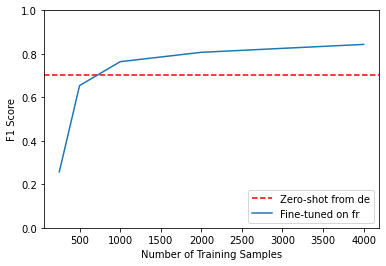

In [75]:
fig, ax = plt.subplots()
ax.axhline(f1_scores["de"]["fr"], ls="--", color="r")
metrics_df.set_index("num_samples").plot(ax=ax)
plt.legend(["Zero-shot from de", "Fine-tuned on fr"], loc="lower right")
plt.ylim((0, 1))
plt.xlabel("Number of Training Samples")
plt.ylabel("F1 Score")
plt.show()

In [76]:
panx_de_encoded

''' DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 12580
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 6290
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 6290
    })
}) '''

" DatasetDict({\n    train: Dataset({\n        features: ['input_ids', 'attention_mask', 'labels'],\n        num_rows: 12580\n    })\n    validation: Dataset({\n        features: ['input_ids', 'attention_mask', 'labels'],\n        num_rows: 6290\n    })\n    test: Dataset({\n        features: ['input_ids', 'attention_mask', 'labels'],\n        num_rows: 6290\n    })\n}) "

In [77]:
panx_de_encoded.keys()
# dict_keys(['train', 'validation', 'test'])

dict_keys(['train', 'validation', 'test'])

In [78]:
from datasets import concatenate_datasets

def concatenate_splits(corpora):
    """
    Function to concatenate multiple corpora together, and shuffle the result.

    Parameters:
    corpora (list): A list of corpora, where each corpus is an instance of DatasetDict from the HuggingFace `datasets` library.
                     Each DatasetDict should contain the same train/validation/test splits.

    Returns:
    multi_corpus (DatasetDict): A DatasetDict containing the concatenated and shuffled datasets.
    """

    # Initialize an empty DatasetDict to hold the concatenated datasets.
    multi_corpus = DatasetDict()

    # For each split (train, validation, test) in the first corpus in the list...
    for train_val_test_split in corpora[0].keys():

        # Concatenate the corresponding split from all corpora in the list.
        # The `concatenate_datasets` function from HuggingFace `datasets` is used here.
        # The concatenated dataset is then shuffled with a fixed seed for reproducibility.
        multi_corpus[train_val_test_split] = concatenate_datasets(
            [corpus[train_val_test_split] for corpus in corpora]).shuffle(seed=42)

    # Return the concatenated and shuffled DatasetDict.
    return multi_corpus


In [79]:
panx_de_fr_concatenated_encoded = concatenate_splits([panx_de_encoded, panx_fr_encoded])

In [80]:

training_args.logging_steps = len(panx_de_fr_concatenated_encoded["train"]) // batch_size
# training_args.push_to_hub = True
training_args.push_to_hub = False  # PAUL - Changing to False
training_args.output_dir = "xlm-roberta-base-finetuned-panx-de-fr"

trainer = Trainer(model_init=model_init, args=training_args,
    data_collator=data_collator, compute_metrics=compute_metrics,
    tokenizer=xlmr_tokenizer, train_dataset=panx_de_fr_concatenated_encoded["train"],
    eval_dataset=panx_de_fr_concatenated_encoded["validation"])

trainer.train()
# trainer.push_to_hub(commit_message="Training completed!")  # PAUL - COMMENTING OUT

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch,Training Loss,Validation Loss,F1
1,0.285400,0.183071,0.823534
2,0.149700,0.159730,0.848593
3,0.096100,0.160419,0.860103


eval_pred.predictions  [[[ 2.1377685e+00 -7.3056984e-01 -1.2598184e+00 ... -4.7928718e-01
   -5.4880399e-01 -1.4730066e-01]
  [ 8.2309427e+00 -2.0092292e+00 -2.3204882e+00 ... -1.3796846e+00
   -1.2631409e+00 -1.4006596e+00]
  [ 8.2432051e+00 -2.4137337e+00 -2.0702550e+00 ... -8.5598320e-01
   -1.8062910e+00 -9.0289891e-01]
  ...
  [-1.0000000e+02 -1.0000000e+02 -1.0000000e+02 ... -1.0000000e+02
   -1.0000000e+02 -1.0000000e+02]
  [-1.0000000e+02 -1.0000000e+02 -1.0000000e+02 ... -1.0000000e+02
   -1.0000000e+02 -1.0000000e+02]
  [-1.0000000e+02 -1.0000000e+02 -1.0000000e+02 ... -1.0000000e+02
   -1.0000000e+02 -1.0000000e+02]]

 [[ 2.5173934e+00 -2.0759494e+00 -2.6205986e+00 ... -1.7687498e+00
    2.2808824e+00 -1.9617949e-01]
  [ 6.5400515e+00 -1.7168512e+00 -2.6269498e+00 ... -1.7725747e+00
    2.3659371e-01 -1.9938818e+00]
  [ 7.3535876e+00 -2.3388042e+00 -2.3144970e+00 ... -8.2872742e-01
   -1.1674420e+00 -1.3158110e+00]
  ...
  [-1.0000000e+02 -1.0000000e+02 -1.0000000e+02 ... -1

TrainOutput(global_step=2145, training_loss=0.17707352360367498, metrics={'train_runtime': 704.6539, 'train_samples_per_second': 73.057, 'train_steps_per_second': 3.044, 'total_flos': 1139987211037488.0, 'train_loss': 0.17707352360367498, 'epoch': 3.0})

In [81]:

for lang in languages:
    f1 = evaluate_lang_performance(lang, trainer)
    print(f"F1-score of [de-fr] model on [{lang}] dataset: {f1:.3f}")

  0%|          | 0/13 [00:00<?, ?ba/s]

Loading cached processed dataset at /root/.cache/huggingface/datasets/xtreme/PAN-X.de/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-7d24f9a603566431.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/xtreme/PAN-X.de/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-c1c2d298fc80b661.arrow


eval_pred.predictions  [[[   1.3811793    -1.4601814    -1.4864641  ...   -0.7152105
      0.45609555    1.3456137 ]
  [   8.85643      -1.907472     -1.8204554  ...   -1.5364349
     -1.2552114    -1.9830589 ]
  [   8.842626     -1.9747117    -1.6426075  ...   -1.4968807
     -1.277305     -1.7088412 ]
  ...
  [-100.         -100.         -100.         ... -100.
   -100.         -100.        ]
  [-100.         -100.         -100.         ... -100.
   -100.         -100.        ]
  [-100.         -100.         -100.         ... -100.
   -100.         -100.        ]]

 [[   3.9538596     0.23638825   -0.40136725 ...   -0.14519846
     -1.6884784    -2.9463322 ]
  [   9.100584     -1.7412996    -1.5358851  ...   -1.38766
     -1.6375059    -2.2748406 ]
  [  -3.0636625     7.0976853    -1.1747248  ...   -1.3090739
     -0.2564517    -3.469692  ]
  ...
  [-100.         -100.         -100.         ... -100.
   -100.         -100.        ]
  [-100.         -100.         -100.         ... -10

Loading cached processed dataset at /root/.cache/huggingface/datasets/xtreme/PAN-X.fr/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-92119c01382f718a.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/xtreme/PAN-X.fr/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-df08c9bf8a078f41.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/xtreme/PAN-X.fr/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-5a8067996ffe172e.arrow


F1-score of [de-fr] model on [de] dataset: 0.868


eval_pred.predictions  [[[   0.13365936    2.1108885     2.0126965  ...   -0.7285474
     -0.93652236   -3.0824475 ]
  [   8.304991     -1.8576213    -1.0123997  ...   -1.3043203
     -2.0060797    -2.4706943 ]
  [   8.309917     -1.8949113    -0.9400138  ...   -1.1204985
     -1.8162805    -2.4375947 ]
  ...
  [-100.         -100.         -100.         ... -100.
   -100.         -100.        ]
  [-100.         -100.         -100.         ... -100.
   -100.         -100.        ]
  [-100.         -100.         -100.         ... -100.
   -100.         -100.        ]]

 [[   1.7909784    -1.1475158    -1.8909172  ...   -1.2611046
      1.515957     -0.2642471 ]
  [   7.754794     -1.6979463    -1.876584   ...   -2.1544135
     -0.64563334   -2.5751657 ]
  [   7.795175     -2.0806787    -1.706418   ...   -1.8553467
     -0.8363235    -2.3637307 ]
  ...
  [-100.         -100.         -100.         ... -100.
   -100.         -100.        ]
  [-100.         -100.         -100.         ... -1

Loading cached processed dataset at /root/.cache/huggingface/datasets/xtreme/PAN-X.it/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-d1da61ce8ecf686a.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/xtreme/PAN-X.it/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-e071a6993a6540a5.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/xtreme/PAN-X.it/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-dc3ad1640cb4e180.arrow


eval_pred.predictions  [[[ 2.6234918e+00 -1.7722435e+00 -2.3634210e+00 ...  4.0771198e-01
   -8.9646488e-02 -9.7554380e-01]
  [ 8.8013525e+00 -2.0324528e+00 -1.6802101e+00 ... -1.8695476e+00
   -8.7998730e-01 -2.1281977e+00]
  [ 8.4929924e+00 -2.1782925e+00 -1.9036101e+00 ... -1.5718662e+00
   -7.9952896e-01 -1.5392929e+00]
  ...
  [-1.0000000e+02 -1.0000000e+02 -1.0000000e+02 ... -1.0000000e+02
   -1.0000000e+02 -1.0000000e+02]
  [-1.0000000e+02 -1.0000000e+02 -1.0000000e+02 ... -1.0000000e+02
   -1.0000000e+02 -1.0000000e+02]
  [-1.0000000e+02 -1.0000000e+02 -1.0000000e+02 ... -1.0000000e+02
   -1.0000000e+02 -1.0000000e+02]]

 [[ 3.0252202e+00 -1.8215035e+00 -2.0893064e+00 ... -1.3164822e+00
    7.3975354e-01  4.8061293e-01]
  [ 8.8729744e+00 -2.1427836e+00 -2.1267653e+00 ... -1.8493363e+00
   -8.4754431e-01 -1.8851765e+00]
  [ 8.7639751e+00 -2.3599620e+00 -1.7226259e+00 ... -1.4296449e+00
   -1.4039841e+00 -1.4490407e+00]
  ...
  [-1.0000000e+02 -1.0000000e+02 -1.0000000e+02 ... -1

Loading cached processed dataset at /root/.cache/huggingface/datasets/xtreme/PAN-X.en/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-9c7d0d5777a90be6.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/xtreme/PAN-X.en/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-8f6662f67966a072.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/xtreme/PAN-X.en/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-bb9f36423604015e.arrow


F1-score of [de-fr] model on [it] dataset: 0.797


eval_pred.predictions  [[[ 4.9367619e+00 -1.5472754e+00 -2.0897160e+00 ... -3.2527724e-01
   -6.2864864e-01 -2.3695116e+00]
  [ 9.0529938e+00 -1.9799951e+00 -1.5045127e+00 ... -1.4186020e+00
   -1.5008993e+00 -2.2779243e+00]
  [ 9.0453911e+00 -2.3747511e+00 -1.4446000e+00 ... -1.2523878e+00
   -1.6009933e+00 -1.8569047e+00]
  ...
  [-1.0000000e+02 -1.0000000e+02 -1.0000000e+02 ... -1.0000000e+02
   -1.0000000e+02 -1.0000000e+02]
  [-1.0000000e+02 -1.0000000e+02 -1.0000000e+02 ... -1.0000000e+02
   -1.0000000e+02 -1.0000000e+02]
  [-1.0000000e+02 -1.0000000e+02 -1.0000000e+02 ... -1.0000000e+02
   -1.0000000e+02 -1.0000000e+02]]

 [[ 1.1097862e+00  2.0969613e+00  3.1437287e+00 ... -1.3596536e+00
   -1.6978847e+00 -2.7673504e+00]
  [-2.2467561e+00  8.1530390e+00 -5.0551426e-01 ... -1.5543641e+00
   -1.0761261e+00 -3.3174269e+00]
  [-1.6459581e+00 -1.0430148e+00  7.2840986e+00 ...  1.1135731e+00
   -2.6066999e+00 -1.0346651e+00]
  ...
  [-1.0000000e+02 -1.0000000e+02 -1.0000000e+02 ... -1

#### Comparing the performance of fine-tuning on each language separately against multilingual learning on all the corpora.


Since we have already fine-tuned on the German corpus, we can fine-tune on
the remaining languages with our **`fine_tuning_training_on_single_corpus()`** function, with num_samples equal to the number of examples in the training set:

#### Note this `fine_tuning_training_on_single_corpus()` has the full training code for a single dataset. So it will take quite a bit of time to run the below cell as Full Training will be executed on each of the different language-corpus.

In [82]:

corpora = [panx_de_encoded]

# Exclude German from iteration
for lang in languages[1:]:
    training_args.output_dir = f"xlm-roberta-base-finetuned-panx-{lang}"
    # Fine-tune on monolingual corpus
    ds_encoded = encode_panx_dataset(panx_ds_combined[lang])
    metrics = fine_tuning_training_on_single_corpus(ds_encoded, ds_encoded["train"].num_rows)
    # Collect F1-scores in common dict
    f1_scores[lang][lang] = metrics["f1_score"][0]
    # Add monolingual corpus to list of corpora to concatenate
    corpora.append(ds_encoded)

Loading cached processed dataset at /root/.cache/huggingface/datasets/xtreme/PAN-X.fr/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-92119c01382f718a.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/xtreme/PAN-X.fr/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-df08c9bf8a078f41.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/xtreme/PAN-X.fr/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-5a8067996ffe172e.arrow
Loading cached shuffled indices for dataset at /root/.cache/huggingface/datasets/xtreme/PAN-X.fr/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-80d9e756466ec551.arrow
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_depr

Epoch,Training Loss,Validation Loss,F1
1,0.547100,0.318010,0.774057
2,0.262900,0.287602,0.826218
3,0.180400,0.272368,0.841891


eval_pred.predictions  [[[ 5.0425255e-01 -1.3537556e-01 -6.2853122e-01 ... -5.2712657e-03
   -6.5075189e-01  2.7888361e-01]
  [-1.4131128e+00  5.6016569e+00 -4.5227185e-01 ... -1.7317444e+00
    1.5323001e-01 -3.1015322e+00]
  [-1.1516833e+00  2.6841943e+00  3.3921769e+00 ... -3.2072619e-01
   -2.1890142e+00 -1.2911124e+00]
  ...
  [-1.0000000e+02 -1.0000000e+02 -1.0000000e+02 ... -1.0000000e+02
   -1.0000000e+02 -1.0000000e+02]
  [-1.0000000e+02 -1.0000000e+02 -1.0000000e+02 ... -1.0000000e+02
   -1.0000000e+02 -1.0000000e+02]
  [-1.0000000e+02 -1.0000000e+02 -1.0000000e+02 ... -1.0000000e+02
   -1.0000000e+02 -1.0000000e+02]]

 [[ 3.4210643e-01 -4.0894052e-01 -7.2958332e-01 ...  2.9312393e-01
   -6.0974610e-01  6.1789179e-01]
  [ 5.9397902e+00 -1.1361338e+00 -9.9149245e-01 ... -1.1154945e+00
   -4.7490063e-01 -2.1339757e+00]
  [ 5.4439330e+00 -1.7030106e+00 -7.8766102e-01 ... -9.1369063e-01
   -7.0414370e-01 -1.6895144e+00]
  ...
  [-1.0000000e+02 -1.0000000e+02 -1.0000000e+02 ... -1

eval_pred.predictions  [[[ 1.15762842e+00 -1.47984065e-02 -8.04894447e-01 ... -1.68146506e-01
   -7.54665613e-01 -1.50814116e-01]
  [ 7.22217941e+00 -1.42589951e+00 -1.24908090e+00 ... -1.30231833e+00
   -1.86545157e+00 -2.09823108e+00]
  [ 7.20115137e+00 -1.20987892e+00 -1.09086084e+00 ... -1.34134877e+00
   -1.76341057e+00 -2.26010084e+00]
  ...
  [-1.00000000e+02 -1.00000000e+02 -1.00000000e+02 ... -1.00000000e+02
   -1.00000000e+02 -1.00000000e+02]
  [-1.00000000e+02 -1.00000000e+02 -1.00000000e+02 ... -1.00000000e+02
   -1.00000000e+02 -1.00000000e+02]
  [-1.00000000e+02 -1.00000000e+02 -1.00000000e+02 ... -1.00000000e+02
   -1.00000000e+02 -1.00000000e+02]]

 [[ 2.20875096e+00 -5.35217047e-01 -1.91191149e+00 ... -1.09106934e+00
    1.01995599e+00 -2.68468469e-01]
  [ 6.82000113e+00 -1.15437984e+00 -1.55306768e+00 ... -1.81308699e+00
   -7.49831557e-01 -2.61019373e+00]
  [ 6.96833181e+00 -1.90371180e+00 -9.87802446e-01 ... -1.31672275e+00
   -1.35179746e+00 -1.84793234e+00]
  ...


Loading cached processed dataset at /root/.cache/huggingface/datasets/xtreme/PAN-X.it/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-d1da61ce8ecf686a.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/xtreme/PAN-X.it/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-e071a6993a6540a5.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/xtreme/PAN-X.it/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-dc3ad1640cb4e180.arrow


Epoch,Training Loss,Validation Loss,F1
1,0.709300,0.332487,0.741068
2,0.291800,0.268984,0.796907
3,0.180100,0.247502,0.822857


eval_pred.predictions  [[[ 2.80071139e-01  1.15186885e-01 -9.79367495e-01 ... -1.94526643e-01
    7.28902221e-01  4.21614021e-01]
  [ 5.98566866e+00 -1.77139831e+00 -1.48365712e+00 ... -6.13943458e-01
   -5.79200163e-02 -1.37588930e+00]
  [ 6.06399775e+00 -1.82995462e+00 -1.33918858e+00 ... -4.63707566e-01
   -5.05947351e-01 -1.09453630e+00]
  ...
  [ 2.50760406e-01 -2.66857177e-01 -8.60749006e-01 ... -4.09304142e-01
    7.37210631e-01  2.44390905e-01]
  [ 2.50760406e-01 -2.66857177e-01 -8.60749006e-01 ... -4.09304142e-01
    7.37210631e-01  2.44390905e-01]
  [ 2.50760406e-01 -2.66857177e-01 -8.60749006e-01 ... -4.09304142e-01
    7.37210631e-01  2.44390905e-01]]

 [[ 1.45614386e+00 -1.20291531e-01 -1.01672781e+00 ... -1.23703308e-01
   -4.19911355e-01 -2.72732466e-01]
  [ 6.30156946e+00 -1.62766767e+00 -1.22171986e+00 ... -6.31114244e-01
   -6.06474519e-01 -1.35395098e+00]
  [ 7.15667248e+00 -2.25324821e+00 -1.40170801e+00 ... -7.49725759e-01
   -1.04408538e+00 -1.20708025e+00]
  ...


eval_pred.predictions  [[[ 7.8188926e-01 -7.6823026e-02 -8.5669750e-01 ... -1.3643132e-01
   -5.0978035e-01  1.4746037e-01]
  [ 7.2378178e+00 -1.9355386e+00 -6.2783802e-01 ... -1.7007271e+00
   -9.0517962e-01 -1.7615310e+00]
  [ 7.0137644e+00 -1.7634940e+00 -1.1340739e+00 ... -1.5350876e+00
   -7.0575738e-01 -1.6335953e+00]
  ...
  [-1.0000000e+02 -1.0000000e+02 -1.0000000e+02 ... -1.0000000e+02
   -1.0000000e+02 -1.0000000e+02]
  [-1.0000000e+02 -1.0000000e+02 -1.0000000e+02 ... -1.0000000e+02
   -1.0000000e+02 -1.0000000e+02]
  [-1.0000000e+02 -1.0000000e+02 -1.0000000e+02 ... -1.0000000e+02
   -1.0000000e+02 -1.0000000e+02]]

 [[ 8.9902860e-01 -4.1968107e-02 -9.6865600e-01 ... -2.7319741e-01
   -3.1628236e-01  2.6962712e-01]
  [ 7.1221099e+00 -1.6336442e+00 -9.4876200e-01 ... -1.5766616e+00
   -9.7348374e-01 -1.9714366e+00]
  [ 7.4429326e+00 -1.9991225e+00 -1.0359839e+00 ... -1.3084871e+00
   -1.5491306e+00 -1.4602226e+00]
  ...
  [-1.0000000e+02 -1.0000000e+02 -1.0000000e+02 ... -1

Loading cached processed dataset at /root/.cache/huggingface/datasets/xtreme/PAN-X.en/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-9c7d0d5777a90be6.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/xtreme/PAN-X.en/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-8f6662f67966a072.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/xtreme/PAN-X.en/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-bb9f36423604015e.arrow


Epoch,Training Loss,Validation Loss,F1
1,1.022300,0.498726,0.577873
2,0.493900,0.399291,0.660773
3,0.362300,0.373787,0.697207


eval_pred.predictions  [[[ 3.1733844e-01 -1.7696494e-01 -7.9041970e-01 ...  2.2110416e-01
   -5.9518802e-01  4.4413266e-01]
  [ 4.8934770e+00 -1.4914415e+00 -9.4258225e-01 ...  3.2855469e-01
   -1.3840483e+00 -1.1328795e+00]
  [ 1.2282220e+00 -4.1129351e-01 -8.7591094e-01 ...  1.1821489e+00
   -5.3672463e-01 -1.0354943e+00]
  ...
  [-1.0000000e+02 -1.0000000e+02 -1.0000000e+02 ... -1.0000000e+02
   -1.0000000e+02 -1.0000000e+02]
  [-1.0000000e+02 -1.0000000e+02 -1.0000000e+02 ... -1.0000000e+02
   -1.0000000e+02 -1.0000000e+02]
  [-1.0000000e+02 -1.0000000e+02 -1.0000000e+02 ... -1.0000000e+02
   -1.0000000e+02 -1.0000000e+02]]

 [[ 4.6711147e-01 -2.2652930e-01 -7.6079881e-01 ... -4.3312687e-02
   -5.6792396e-01  4.6648088e-01]
  [ 6.1253095e+00 -1.4965594e+00 -8.8580310e-01 ... -5.6415892e-01
   -1.5338635e+00 -1.1779287e+00]
  [ 5.0220962e+00 -1.0574641e+00 -7.0078850e-01 ... -6.7236483e-01
   -9.8756522e-01 -1.5546021e+00]
  ...
  [-1.0000000e+02 -1.0000000e+02 -1.0000000e+02 ... -1

eval_pred.predictions  [[[ 5.6751502e-01 -2.6132488e-01 -7.7602798e-01 ... -1.0058281e-02
   -6.0254061e-01  3.9059958e-01]
  [ 6.5348849e+00 -1.5539528e+00 -1.6618949e+00 ... -6.6485405e-01
   -1.3087538e+00 -1.6130887e+00]
  [ 6.5021644e+00 -1.6827965e+00 -1.6360095e+00 ... -5.9766191e-01
   -1.4464902e+00 -1.3725111e+00]
  ...
  [-1.0000000e+02 -1.0000000e+02 -1.0000000e+02 ... -1.0000000e+02
   -1.0000000e+02 -1.0000000e+02]
  [-1.0000000e+02 -1.0000000e+02 -1.0000000e+02 ... -1.0000000e+02
   -1.0000000e+02 -1.0000000e+02]
  [-1.0000000e+02 -1.0000000e+02 -1.0000000e+02 ... -1.0000000e+02
   -1.0000000e+02 -1.0000000e+02]]

 [[ 3.4705952e-01  6.9233678e-02 -5.5396092e-01 ... -1.1049560e-01
   -6.9639808e-01  3.3554932e-01]
  [-8.0745751e-01  5.0687537e+00 -6.8267834e-01 ... -1.7894850e+00
   -4.6550125e-01 -2.4104626e+00]
  [-1.2124417e+00  1.0630804e-01  4.8754258e+00 ...  1.0298392e+00
   -1.9383799e+00 -8.1971925e-01]
  ...
  [-1.0000000e+02 -1.0000000e+02 -1.0000000e+02 ... -1

In [83]:
corpora_encoded = concatenate_splits(corpora)

In [84]:

training_args.logging_steps = len(corpora_encoded["train"]) // batch_size
training_args.output_dir = "xlm-roberta-base-finetuned-panx-all"

trainer = Trainer(model_init=model_init, args=training_args,
    data_collator=data_collator, compute_metrics=compute_metrics,
    tokenizer=xlmr_tokenizer, train_dataset=corpora_encoded["train"],
    eval_dataset=corpora_encoded["validation"])

trainer.train()
# trainer.push_to_hub(commit_message="Training completed!") # PAUL - COMMENTING OUT

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch,Training Loss,Validation Loss,F1
1,0.299200,0.193584,0.816409
2,0.158800,0.171052,0.846557
3,0.102200,0.173101,0.852467


eval_pred.predictions  [[[ 2.9919024e+00 -7.6689059e-01 -1.4890326e+00 ... -6.7211676e-01
   -5.8668792e-01 -6.7394668e-01]
  [ 8.0442200e+00 -2.0944490e+00 -2.1246192e+00 ... -5.6890202e-01
   -1.9451729e+00 -1.7060621e+00]
  [ 7.7958932e+00 -2.2906582e+00 -2.0266480e+00 ... -3.9295155e-01
   -1.9943413e+00 -1.3476235e+00]
  ...
  [-1.0000000e+02 -1.0000000e+02 -1.0000000e+02 ... -1.0000000e+02
   -1.0000000e+02 -1.0000000e+02]
  [-1.0000000e+02 -1.0000000e+02 -1.0000000e+02 ... -1.0000000e+02
   -1.0000000e+02 -1.0000000e+02]
  [-1.0000000e+02 -1.0000000e+02 -1.0000000e+02 ... -1.0000000e+02
   -1.0000000e+02 -1.0000000e+02]]

 [[ 2.8786671e+00 -1.2848481e+00 -1.6121919e+00 ... -6.7919368e-01
   -1.9804814e-01  3.9747661e-01]
  [ 1.6063884e+00  4.7341388e-01 -3.6248176e+00 ... -2.3605833e+00
    4.6657639e+00 -1.9360447e+00]
  [ 1.3269771e+00 -1.8284042e+00 -1.5502671e+00 ... -3.0514562e-01
    1.4326315e+00  1.6327080e+00]
  ...
  [-1.0000000e+02 -1.0000000e+02 -1.0000000e+02 ... -1

TrainOutput(global_step=2505, training_loss=0.18659199897400633, metrics={'train_runtime': 816.8133, 'train_samples_per_second': 73.53, 'train_steps_per_second': 3.067, 'total_flos': 1308863997899304.0, 'train_loss': 0.18659199897400633, 'epoch': 3.0})

In [85]:

for idx, lang in enumerate(languages):
    f1_scores["all"][lang] = get_f1_score(trainer, corpora[idx]["test"])

eval_pred.predictions  [[[ 7.9403543e-01 -1.2328169e+00 -1.1343009e+00 ... -3.5954663e-01
    5.5029955e-02  1.7563232e+00]
  [ 8.7740116e+00 -1.9510223e+00 -2.0150390e+00 ... -1.7945001e+00
   -1.7943008e+00 -1.9372224e+00]
  [ 8.7262363e+00 -1.8768736e+00 -2.0282381e+00 ... -1.7946838e+00
   -1.7372109e+00 -1.9021082e+00]
  ...
  [-1.0000000e+02 -1.0000000e+02 -1.0000000e+02 ... -1.0000000e+02
   -1.0000000e+02 -1.0000000e+02]
  [-1.0000000e+02 -1.0000000e+02 -1.0000000e+02 ... -1.0000000e+02
   -1.0000000e+02 -1.0000000e+02]
  [-1.0000000e+02 -1.0000000e+02 -1.0000000e+02 ... -1.0000000e+02
   -1.0000000e+02 -1.0000000e+02]]

 [[ 3.1357555e+00 -2.4435581e-01 -4.9560294e-01 ...  2.8678373e-01
   -1.8097545e+00 -2.4668186e+00]
  [ 9.4032402e+00 -1.8462368e+00 -2.1455066e+00 ... -1.5149575e+00
   -1.9847606e+00 -1.7469230e+00]
  [-2.5444090e+00  7.4705591e+00 -1.1881567e+00 ... -1.2337635e+00
   -7.3743641e-01 -3.8617780e+00]
  ...
  [-1.0000000e+02 -1.0000000e+02 -1.0000000e+02 ... -1

eval_pred.predictions  [[[ 1.1433227e+00  3.3091167e-01  1.0137870e-01 ... -3.0032197e-01
   -1.2668253e+00 -1.2383301e+00]
  [ 8.4667873e+00 -1.5044104e+00 -1.6150807e+00 ... -1.6498197e+00
   -2.1245172e+00 -2.4466200e+00]
  [ 8.4561510e+00 -1.7117666e+00 -1.1377261e+00 ... -1.2974257e+00
   -2.3000474e+00 -2.3163204e+00]
  ...
  [-1.0000000e+02 -1.0000000e+02 -1.0000000e+02 ... -1.0000000e+02
   -1.0000000e+02 -1.0000000e+02]
  [-1.0000000e+02 -1.0000000e+02 -1.0000000e+02 ... -1.0000000e+02
   -1.0000000e+02 -1.0000000e+02]
  [-1.0000000e+02 -1.0000000e+02 -1.0000000e+02 ... -1.0000000e+02
   -1.0000000e+02 -1.0000000e+02]]

 [[ 1.6842725e+00 -9.3407941e-01 -1.5313141e+00 ... -9.4526792e-01
    2.6799738e-01 -7.2772004e-02]
  [ 7.5703006e+00 -9.7942120e-01 -2.7906024e+00 ... -2.2422421e+00
   -4.0735090e-01 -2.5636103e+00]
  [ 7.0775766e+00 -1.6942604e+00 -2.4678667e+00 ... -1.8710165e+00
   -3.8173041e-01 -2.1424766e+00]
  ...
  [-1.0000000e+02 -1.0000000e+02 -1.0000000e+02 ... -1

eval_pred.predictions  [[[ 2.37664986e+00 -1.18980038e+00 -1.40319681e+00 ...  2.69460589e-01
   -9.57246840e-01 -3.41033250e-01]
  [ 9.00279617e+00 -2.05867219e+00 -2.21058798e+00 ... -1.87437618e+00
   -1.38784897e+00 -1.75782955e+00]
  [ 8.93927097e+00 -2.26200199e+00 -2.39393759e+00 ... -1.67596889e+00
   -1.32777250e+00 -1.58036625e+00]
  ...
  [-1.00000000e+02 -1.00000000e+02 -1.00000000e+02 ... -1.00000000e+02
   -1.00000000e+02 -1.00000000e+02]
  [-1.00000000e+02 -1.00000000e+02 -1.00000000e+02 ... -1.00000000e+02
   -1.00000000e+02 -1.00000000e+02]
  [-1.00000000e+02 -1.00000000e+02 -1.00000000e+02 ... -1.00000000e+02
   -1.00000000e+02 -1.00000000e+02]]

 [[ 4.60199785e+00 -2.52526164e+00 -2.59831595e+00 ... -1.54326129e+00
    4.21657205e-01  5.60146153e-01]
  [ 8.98218632e+00 -2.02827954e+00 -2.34604955e+00 ... -1.68379533e+00
   -1.47733700e+00 -1.75530493e+00]
  [ 9.20008945e+00 -2.32323790e+00 -2.09513474e+00 ... -1.52083611e+00
   -1.93531907e+00 -1.27233791e+00]
  ...


eval_pred.predictions  [[[ 4.99528790e+00 -1.99973273e+00 -1.99247622e+00 ... -7.10512519e-01
   -7.69161880e-01 -1.96727896e+00]
  [ 9.37466335e+00 -2.13861918e+00 -1.93970203e+00 ... -1.47846460e+00
   -2.12122059e+00 -1.59690106e+00]
  [ 9.30642986e+00 -2.35838914e+00 -1.97116661e+00 ... -1.43320179e+00
   -2.03499126e+00 -1.36883056e+00]
  ...
  [-1.00000000e+02 -1.00000000e+02 -1.00000000e+02 ... -1.00000000e+02
   -1.00000000e+02 -1.00000000e+02]
  [-1.00000000e+02 -1.00000000e+02 -1.00000000e+02 ... -1.00000000e+02
   -1.00000000e+02 -1.00000000e+02]
  [-1.00000000e+02 -1.00000000e+02 -1.00000000e+02 ... -1.00000000e+02
   -1.00000000e+02 -1.00000000e+02]]

 [[ 1.74531853e+00  6.10272765e-01  1.31297600e+00 ... -1.02340531e+00
   -1.61554837e+00 -2.34866476e+00]
  [-1.50250018e+00  8.09914494e+00 -1.76422799e+00 ... -1.94632566e+00
   -7.75494874e-01 -3.79209542e+00]
  [-1.88332856e+00 -9.78822529e-01  7.54941988e+00 ...  1.36956024e+00
   -3.07306957e+00 -1.42559600e+00]
  ...


In [86]:
scores_data = {"de": f1_scores["de"],
               "each": {lang: f1_scores[lang][lang] for lang in languages},
               "all": f1_scores["all"]}
f1_scores_df = pd.DataFrame(scores_data).T.round(4)
f1_scores_df.rename_axis(index="Fine-tune on", columns="Evaluated on",
                         inplace=True)
f1_scores_df

Evaluated on,de,fr,it,en
Fine-tune on,,,,
de,0.8691,0.7016,0.6739,0.5921
each,0.8691,0.8372,0.8178,0.7084
all,0.8697,0.8729,0.8698,0.7724
